In [51]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, plot_confusion_matrix, performance_metrics, ms_label2id, ms_id2label, load_ms_data

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [54]:
def show_results(file_name: str) -> None:
    results = torch.load(paths.RESULTS_PATH / "ms-diag" / f"{file_name}")
    # Last hidden states is a list of tensors of shape (seq_len, hidden_size)
    last_hidden_state = [batch[0, :] for batch in results["last_hidden_state"]]  # Use CLS token
    embeddings = torch.stack(last_hidden_state, dim=0).to(torch.float16)
    labels = [ms_id2label[label] for label in results["labels"]]
    preds = [ms_id2label[pred] for pred in results["preds"]]

    # Plot confusion matrix
    plot_confusion_matrix(preds=preds, labels=labels, title=file_name)
    plt.show()

    # Plot embeddings
    plot_embeddings(embeddings=embeddings, labels=labels, title=file_name)
    plt.show()

    # Print classification report
    print(classification_report(y_true=labels, y_pred=preds), "\n\n")

    # Show all wrongly classified samples
    for i in range(len(labels)):
        if labels[i] != preds[i]:
            print(f"Label: {labels[i]} - Prediction: {preds[i]}")
            print(results["text"][i], "\n\n")

# MedBERT 512

## Strategy: Classify on single lines, 4 Labels (including no MS) and oversampling for training

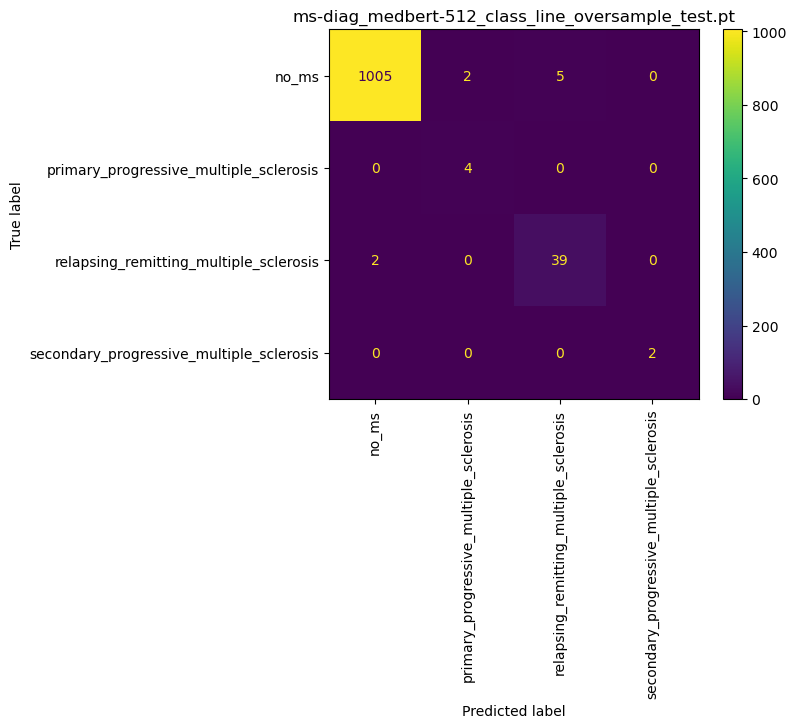

(1059, 2)


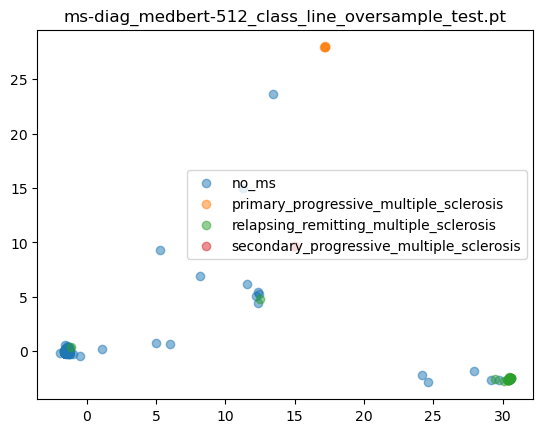

                                          precision    recall  f1-score   support

                                   no_ms       1.00      0.99      1.00      1012
  primary_progressive_multiple_sclerosis       0.67      1.00      0.80         4
  relapsing_remitting_multiple_sclerosis       0.89      0.95      0.92        41
secondary_progressive_multiple_sclerosis       1.00      1.00      1.00         2

                                accuracy                           0.99      1059
                               macro avg       0.89      0.99      0.93      1059
                            weighted avg       0.99      0.99      0.99      1059
 


Label: no_ms - Prediction: relapsing_remitting_multiple_sclerosis
INDENT cMRI 23.08.2017: Bei Multipler Sklerose im Vergleich zur Voruntersuchung einzelne leicht progrediente Läsionen supratentoriell bilateral, eine neue kontrastmittelaufnehmende Läsion im Cingulum links. Die vormalige kontrastmittelaufnehmende Läsion im Pons stellt sic

In [55]:
show_results("ms-diag_medbert-512_class_line_oversample_test.pt")

## Strategy: Classify on single lines, 3 Labels (original approach with only dm samples) and oversampling for training

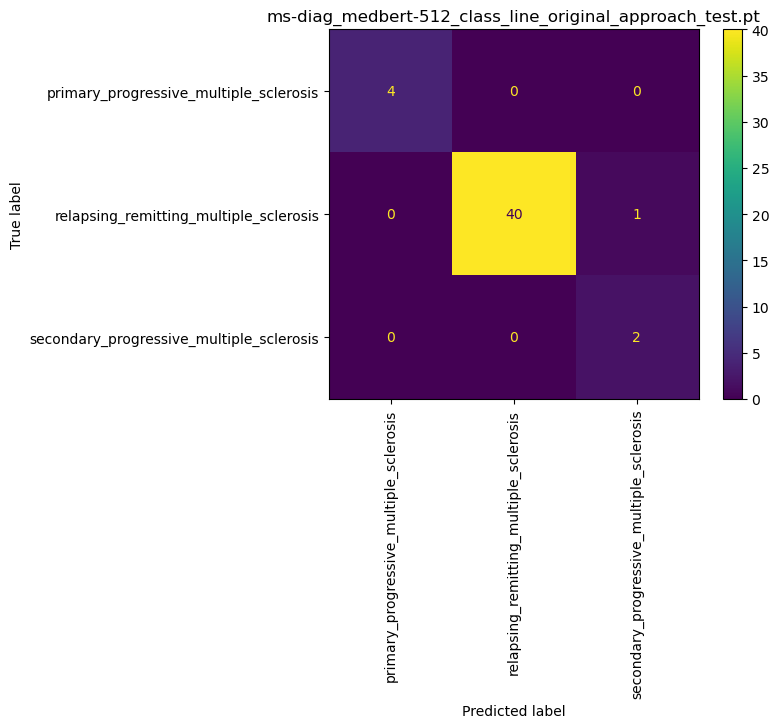

(47, 2)


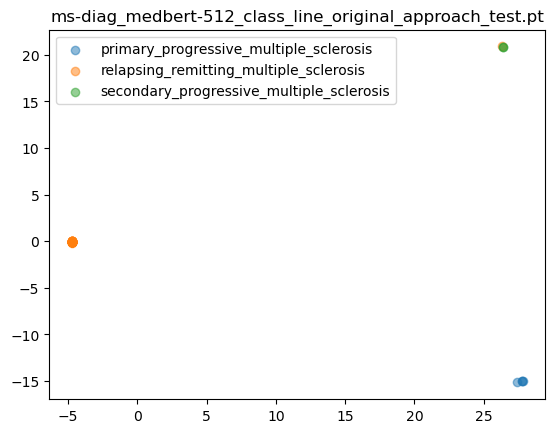

                                          precision    recall  f1-score   support

  primary_progressive_multiple_sclerosis       1.00      1.00      1.00         4
  relapsing_remitting_multiple_sclerosis       1.00      0.98      0.99        41
secondary_progressive_multiple_sclerosis       0.67      1.00      0.80         2

                                accuracy                           0.98        47
                               macro avg       0.89      0.99      0.93        47
                            weighted avg       0.99      0.98      0.98        47
 


Label: relapsing_remitting_multiple_sclerosis - Prediction: secondary_progressive_multiple_sclerosis
Schubförmige Multiple Sklerose mit V. a. sekundär chronisch progredienten Verlauf seit ca. 2016, EM 1997, ED 2003, EDSS 6.0 




In [57]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt")